In [1]:
# подключаем библиотеку
%run libs/pump_unit.ipynb

In [2]:
# файлы с характеристиками насосов
files = ['data/pump.csv',
         'data/pump.csv',
         'data/pump.csv',
         'data/pump.csv']

In [3]:
# шаг изменения параметров при рассчете
flow_step=10.0
head_step=0.2

In [4]:
# первый подъём
pb_1 = PumpBattery(flow_step, head_step, files)
pb_1.calc_units_matrices()

# второй подъём
pb_2 = PumpBattery(flow_step, head_step, files)
pb_2.calc_units_matrices()

In [6]:
# посчитаем один из вариантов работы
scenario = 0
pb_1.calc_mutation_matrix(scenario)
pb_2.calc_mutation_matrix(scenario)

In [8]:
# работа с данными из файлов

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
#sns.set_palette("bright")

# Use palplot and pass in the variable:
#sns.palplot(palette)

In [10]:
# конвертер величин

def convert_unit(kind, value, unit_in, unit_out):
    unit = {
        'head': {'m':1.0, 'kgf_cm2':10.0, 'bar':10.197, 'kPa':0.10197, 'atm':10.33, 'psi':0.70307},
        'flow': {'cbmh':1.0, 'cbms':3600.0, 'lpm':0.06, 'lps':3.6},
        'power': {'kW':1.0, 'W':0.001}
    }
    return value * unit[kind][unit_in] / unit[kind][unit_out]

In [11]:
# читаем показания

log_1 = pd.read_csv('data/log_06_04_2019.csv', sep=';', decimal=',')
log_1["date"] = pd.to_datetime(log_1["date"], format="%d.%m.%Y %H:%M")
log_1.fillna(method ='ffill', inplace=True)

log_2 = pd.read_csv('data/log_21_04_2019.csv', sep=';', decimal=',')
log_2["date"] = pd.to_datetime(log_2["date"], format="%d.%m.%Y %H:%M")
log_2.fillna(method ='ffill', inplace=True)

In [12]:
# объединяем 2 набора данных для обработки

frames = [log_1, log_2]
log = pd.concat(frames, ignore_index=True)

num = log_1.shape[0]

In [13]:
# преобразуем показания давления

head_cols = ['head in', 'head out', 'head in lift 1', 'head out lift 1', 'head in lift 2', 'head out lift 2']
for col in head_cols:
    log[col] = log[col].apply(lambda x: convert_unit('head', x, 'bar', 'm'))

#### Вспомогательные переменные

In [14]:
freq_cols = ['freq unit 1', 'freq unit 2', 'freq unit 3', 'freq unit 3.1', 
             'freq unit 4', 'freq unit 5', 'freq unit 6', 'freq unit 6.1']
freq_cols_1 = freq_cols[:4]
freq_cols_2 = freq_cols[4:]

In [15]:
speed_cols = ['speed unit 1', 'speed unit 2', 'speed unit 3', 'speed unit 3.1',
              'speed unit 4', 'speed unit 5', 'speed unit 6', 'speed unit 6.1']
speed_cols_1 = speed_cols[:4]
speed_cols_2 = speed_cols[4:]

In [16]:
power_sup_cols = ['power sup. unit 1', 'power sup. unit 2', 'power sup. unit 3', 'power sup. unit 3.1',
                  'power sup. unit 4', 'power sup. unit 5', 'power sup. unit 6', 'power sup. unit 6.1']
power_sup_cols_1 = power_sup_cols[:4]
power_sup_cols_2 = power_sup_cols[4:]

In [17]:
power_hydro_cols = ['power hydro unit 1', 'power hydro unit 2', 'power hydro unit 3', 'power hydro unit 3.1',
                    'power hydro unit 4', 'power hydro unit 5', 'power hydro unit 6', 'power hydro unit 6.1']
power_hydro_cols_1 = power_hydro_cols[:4]
power_hydro_cols_2 = power_hydro_cols[4:]

In [18]:
flow_cols = ['flow unit 1', 'flow unit 2', 'flow unit 3', 'flow unit 3.1',
             'flow unit 4', 'flow unit 5', 'flow unit 6', 'flow unit 6.1']
flow_cols_1 = flow_cols[:4]
flow_cols_2 = flow_cols[4:]

In [19]:
power_rate_cols = ['power rate unit 1', 'power rate unit 2', 'power rate unit 3', 'power rate unit 3.1',
                   'power rate unit 4', 'power rate unit 5', 'power rate unit 6', 'power rate unit 6.1']
power_rate_cols_1 = power_rate_cols[:4]
power_rate_cols_2 = power_rate_cols[4:]

In [20]:
eff_actual_cols = ['eff actual unit 1', 'eff actual unit 2', 'eff actual unit 3', 'eff actual unit 3.1',
                   'eff actual unit 4', 'eff actual unit 5', 'eff actual unit 6', 'eff actual unit 6.1']
eff_actual_cols_1 = eff_actual_cols[:4]
eff_actual_cols_2 = eff_actual_cols[4:]

In [21]:
head_labels = ['Вход в котельную', 'Выход из котельной', 'Всас подъём 1', 'Нагнетание подъём 1',
               'Всас подъём 2', 'Нагнетание подъём 2']

In [22]:
lift_labels = ['Подъём 1', 'Подъём 2']

In [23]:
pump_labels = ['Насос 1', 'Насос 2', 'Насос 3', 'Насос 3.1', 'Насос 4', 'Насос 5', 'Насос 6', 'Насос 6.1']

In [24]:
fact_opt_labels = ['Фактический (подъём 1)', 'Фактический (подъём 2)', 
                   'Оптимальный (подъём 1)', 'Оптимальный (подъём 2)']

In [67]:
head_adj_cols = ['head in adj', 'head out adj', 'head in adj lift 1', 'head out adj lift 1', 
                 'head in adj lift 2', 'head out adj lift 2']

#### Вспомогательные функции

In [25]:
def plot_by_date(ncols, dfs, cols, labels, title, y_label):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
    for ncol in range(ncols):
        ax = axes[ncol] if ncols > 1 else axes
        dfs[ncol].plot('date', cols, title=title, ax=ax, label=labels)
        ax.set_ylabel(y_label)
        ax.legend(loc='upper right')
    plt.show()

In [26]:
def plot_dist_kde(data, ax, color):
    sns.distplot(data, ax=ax, kde=False, color=color)
    second_ax = ax.twinx()
    sns.distplot(data, ax=second_ax, kde=True, hist=False, color=color)
    second_ax.set_yticks([])

In [123]:
def plot_dists(ncols, dfs, cols, labels, title, x_label, y_label, xlim=None, ylim=None):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
    for ncol in range(ncols):
        ax = axes[ncol] if ncols > 1 else axes
        for col in cols:
            sns.distplot(dfs[ncol][col], ax=ax)
        ax.set_title(title[ncol])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xlim(0, xlim)
        yl = ylim[ncol] if (ncols > 1 and ylim != None) else ylim
        ax.set_ylim(0, yl)
        ax.legend(labels)

In [28]:
def plot_scatter(df, cols, labels, colors, markers, title, x_label, y_label):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
    for idx, (col, label) in enumerate(zip(cols, labels)):
        df.plot.scatter(col[0], col[1], color=colors[idx], marker=markers[idx], s=50, ax=axes, label=label)
    axes.set_title(title)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_xlim(0, None)
    axes.set_ylim(0, None)
    plt.show()

In [212]:
def plot_flow_head(ncols, dfs, cols, labels, colors, titles, x_label, y_label, xlim=None, ylim=None):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 5))
    for ncol in range(ncols):
        ax = axes[ncol] if ncols > 1 else axes        
        for idx, col in enumerate(cols):
            dfs[ncol].plot.scatter(col[0], col[1], color=colors[idx], s=50, ax=ax, label=labels[idx])
        ax.set_title(titles[ncol])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
    plt.show()

In [78]:
# косвенный поиск расхода каждого насоса через напор и частоту

def get_flow_by_head_speed(unit, head, speed):
    unit.pump.set_speed(speed)
    head_lim = head.copy()
    head_lim[head_lim > unit.pump.head_max] = unit.pump.head_max
    data = quadratic_equation_root(unit.pump.head_c[2], 
                                   unit.pump.head_c[1]*speed, 
                                   head_lim - (unit.pump.head_c[0] * speed**2))
    return pd.Series(data, index=head.index)

In [86]:
# поиск индекса элемента в массиве по значению

def find_index(array, value):
    return (np.abs(np.asarray(array) - value)).argmin()

# поиск ближайшего значения из массива

def find_quant(array, value):
    return array[find_index(array, value)]

#### Расчёты

In [74]:
# корректировка на высоту установки датчиков

head_in_height = 2.0
head_out_height = 2.0

head_in_N_height = 3.1
head_out_N_height = 3.8

log['head in adj'] = log['head in'] - head_in_height
log['head out adj'] = log['head out'] - head_out_height
log[['head in adj lift 1', 'head in adj lift 2']] = log[['head in lift 1', 'head in lift 2']] - head_in_N_height
log[['head out adj lift 1', 'head out adj lift 2']] = log[['head out lift 1', 'head out lift 2']] - head_out_N_height

In [137]:
# напор, сорректированный на высоту установки датчиков

log['head lift 1'] = log['head out adj lift 1'] - log['head in adj lift 1']
log['head lift 2'] = log['head out adj lift 2'] - log['head in adj lift 2']

In [76]:
# считаем относительную скорость, нормируем на максимальную частоту

log[speed_cols] = 0
#log['speed unit 1'], log['speed unit 2'], log['speed unit 3'], log['speed unit 3.1'] = 0, 0, 0, 0
#log['speed unit 4'], log['speed unit 5'], log['speed unit 6'], log['speed unit 6.1'] = 0, 0, 0, 0

for col_1, col_2 in zip(freq_cols, speed_cols):
    log[col_2] = log[col_1] / 50.0

In [77]:
# суммарная мощность насосов

log['power sup. lift 1'] = log[power_sup_cols_1].sum(axis=1)
log['power sup. lift 2'] = log[power_sup_cols_2].sum(axis=1)

In [79]:
# косвенный поиск расхода каждого насоса через напор и частоту

#log['flow unit 1'], log['flow unit 2'], log['flow unit 3'], log['flow unit 3.1'] = 0, 0, 0, 0
#log['flow unit 4'], log['flow unit 5'], log['flow unit 6'], log['flow unit 6.1'] = 0, 0, 0, 0

log[flow_cols] = 0

for idx, (flow, speed) in enumerate(zip(flow_cols_1, speed_cols_1)):
    log[flow] = get_flow_by_head_speed(pb_1.units[idx], log['head lift 1'], log[speed])

for idx, (flow, speed) in enumerate(zip(flow_cols_2, speed_cols_2)):
    log[flow] = get_flow_by_head_speed(pb_2.units[idx], log['head lift 2'], log[speed])

In [80]:
# суммарный расход насосов

log['flow lift 1'] = log[flow_cols_1].sum(axis=1)
log['flow lift 2'] = log[flow_cols_2].sum(axis=1)

In [81]:
#log['power hydro unit 1'], log['power hydro unit 2'], log['power hydro unit 3'], log['power hydro unit 3.1'] = 0, 0, 0, 0
#log['power hydro unit 4'], log['power hydro unit 5'], log['power hydro unit 6'], log['power hydro unit 6.1'] = 0, 0, 0, 0

log[power_hydro_cols] = 0

In [82]:
# расчёт гидравлической мощности

log[power_hydro_cols] = 998.0 * 9.81 * log[flow_cols] / 3600.0 / 1000.0
log[power_hydro_cols_1] = log[power_hydro_cols_1].mul(log['head lift 1'], axis=0)
log[power_hydro_cols_2] = log[power_hydro_cols_2].mul(log['head lift 2'], axis=0)

In [83]:
# суммарная гидравлическая мощность насосов

log['power hydro lift 1'] = log[power_hydro_cols_1].sum(axis=1)
log['power hydro lift 2'] = log[power_hydro_cols_2].sum(axis=1)

In [84]:
# расчёт удельного расхода электроэнергии

log['power rate lift 1'] = log['power sup. lift 1'] / log['flow lift 1']
log['power rate lift 2'] = log['power sup. lift 2'] / log['flow lift 2']

In [85]:
# расчёт КПД

log['eff actual lift 1'] = log['power hydro lift 1'] / log['power sup. lift 1'] * 100.0
log['eff actual lift 2'] = log['power hydro lift 2'] / log['power sup. lift 2'] * 100.0

In [87]:
# квантование напора по уровням с заданным шагом

log['head idx lift 1'] = log['head lift 1'].apply(lambda x: find_index(pb_1.head_points, x))
log['head idx lift 2'] = log['head lift 2'].apply(lambda x: find_index(pb_2.head_points, x))

log['head quant lift 1'] = pb_1.head_points[log['head idx lift 1']]
log['head quant lift 2'] = pb_2.head_points[log['head idx lift 2']]

In [88]:
# квантование расхода по уровням с заданным шагом

log['flow idx lift 1'] = log['flow lift 1'].apply(lambda x: find_index(pb_1.flow_points, x))
log['flow idx lift 2'] = log['flow lift 2'].apply(lambda x: find_index(pb_2.flow_points, x))

log['flow quant lift 1'] = pb_1.flow_points[log['flow idx lift 1']]
log['flow quant lift 2'] = pb_2.flow_points[log['flow idx lift 2']]

In [89]:
# рекомендуемое количество насосов для рассматриваемых режимов работы станции

log['count opt. lift 1'] = [pb_1.count_total_matrix[scenario]
                                                  [log['head idx lift 1'][x]]
                                                  [log['flow idx lift 1'][x]] for x in range(log['head idx lift 1'].shape[0])]

log['count opt. lift 2'] = [pb_2.count_total_matrix[scenario]
                                                  [log['head idx lift 2'][x]]
                                                  [log['flow idx lift 2'][x]] for x in range(log['head idx lift 2'].shape[0])]

In [90]:
# наилучшее КПД для рассматриваемых режимов работы станции

log['eff opt. lift 1'] = [pb_1.eff_total_matrix[scenario]
                                              [log['head idx lift 1'][x]]
                                              [log['flow idx lift 1'][x]] for x in range(log['head idx lift 1'].shape[0])]

log['eff opt. lift 2'] = [pb_2.eff_total_matrix[scenario]
                                              [log['head idx lift 2'][x]]
                                              [log['flow idx lift 2'][x]] for x in range(log['head idx lift 2'].shape[0])]

In [91]:
# оптимальное энергопотребление

log['power sup. opt. lift 1'] = log['power hydro lift 1'] / log['eff opt. lift 1'] * 100.0
log['power sup. opt. lift 2'] = log['power hydro lift 2'] / log['eff opt. lift 2'] * 100.0

In [92]:
# считаем фактическое и оптимальное количество электроэнергии за период наблюдения

pb_1.energy_1 = log[:num]['power sup. lift 1'].sum()
pb_2.energy_1 = log[:num]['power sup. lift 2'].sum()
pb_1.energy_opt_1 = log[:num]['power sup. opt. lift 1'].sum()
pb_2.energy_opt_1 = log[:num]['power sup. opt. lift 2'].sum()

pb_1.energy_2 = log[num:]['power sup. lift 1'].sum()
pb_2.energy_2 = log[num:]['power sup. lift 2'].sum()
pb_1.energy_opt_2 = log[num:]['power sup. opt. lift 1'].sum()
pb_2.energy_opt_2 = log[num:]['power sup. opt. lift 2'].sum()

In [93]:
# расчёт удельного расхода электроэнергии

log['power rate opt. lift 1'] = log['power sup. opt. lift 1'] / log['flow lift 1']
log['power rate opt. lift 2'] = log['power sup. opt. lift 2'] / log['flow lift 2']

#### Графики

##### Характеристики насосов

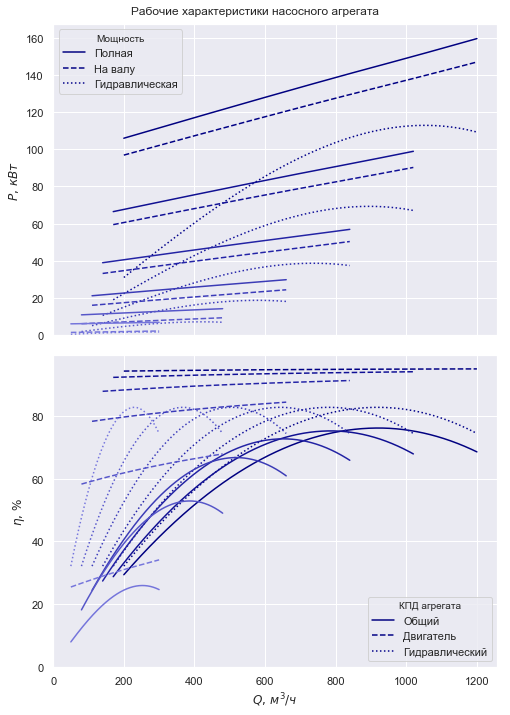

In [5]:
pb_1.units[0].plot_work_curves()

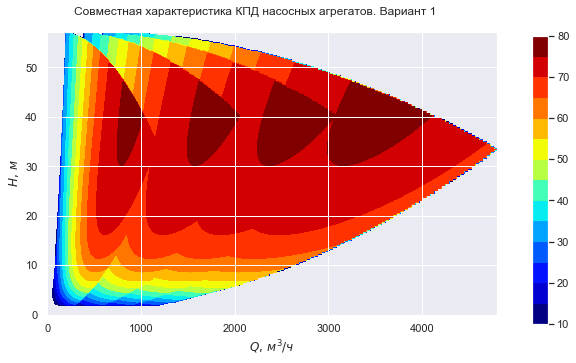

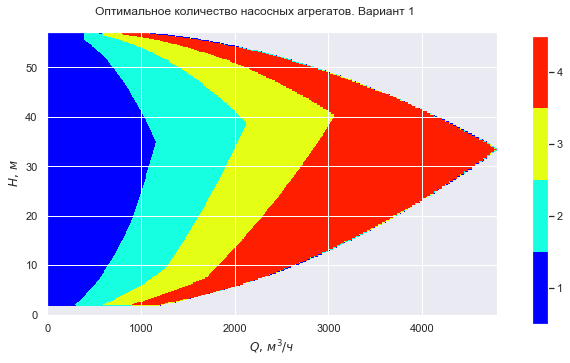

In [7]:
# посмотрим на результат
pb_1.plot_eff_total_map(scenario)
pb_1.plot_count_total_map(scenario)

##### Напор

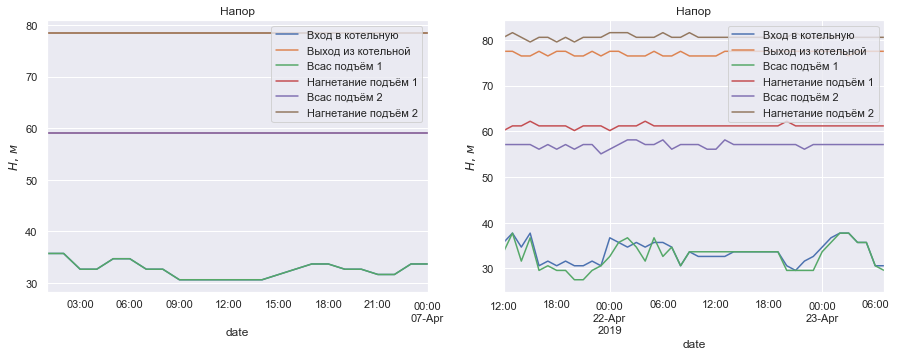

In [33]:
plot_by_date(2, [log[:num], log[num:]], head_cols, head_labels, 'Напор', '$H,\, м$')

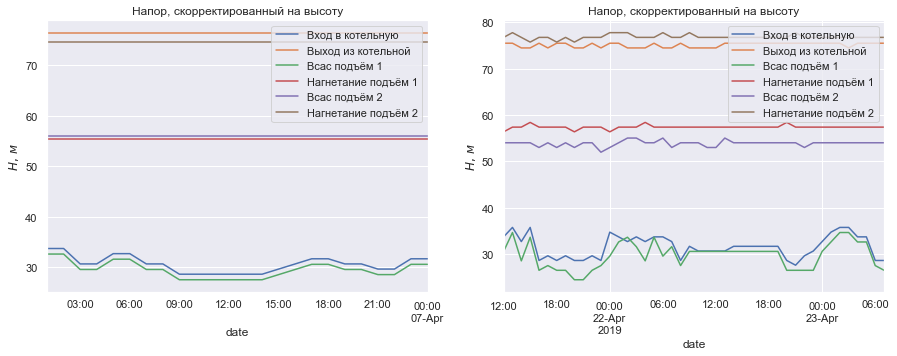

In [134]:
plot_by_date(2, [log[:num], log[num:]], head_adj_cols, head_labels, 'Напор, скорректированный на высоту', '$H,\, м$')

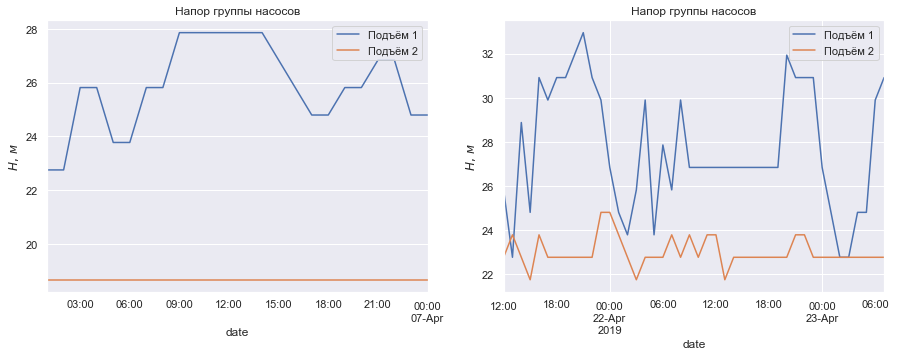

In [37]:
plot_by_date(2, [log[:num], log[num:]], ['head lift 1', 'head lift 2'], lift_labels, 'Напор группы насосов', '$H,\, м$')

##### Частота

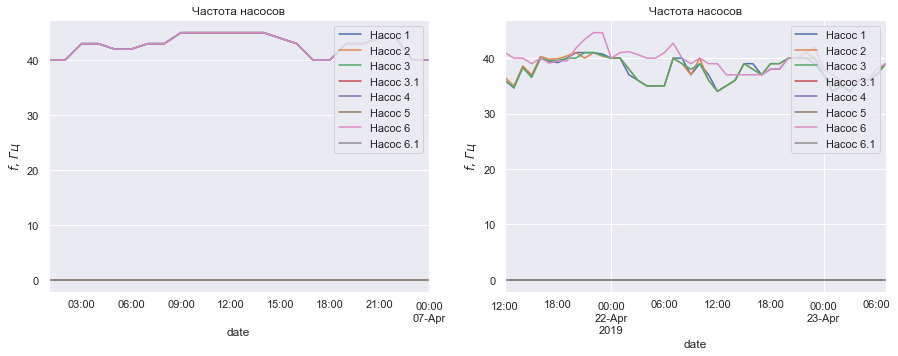

In [38]:
plot_by_date(2, [log[:num], log[num:]], freq_cols, pump_labels, 'Частота насосов', '$f,\, Гц$')

##### Расход

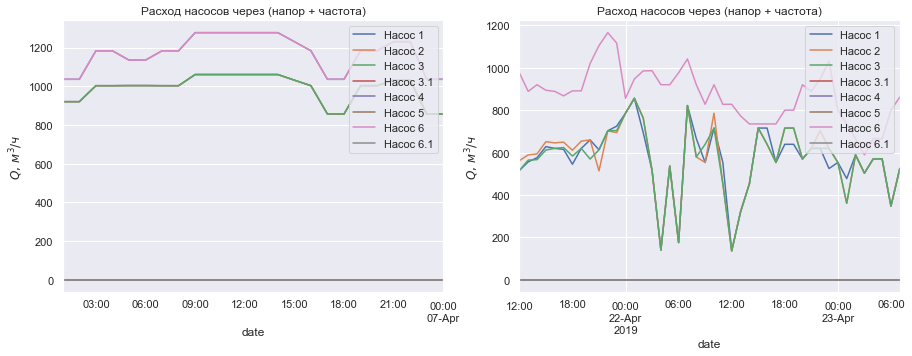

In [132]:
plot_by_date(2, [log[:num], log[num:]], flow_cols, pump_labels, 'Расход насосов через (напор + частота)', '$Q,\, м^3/ч$')

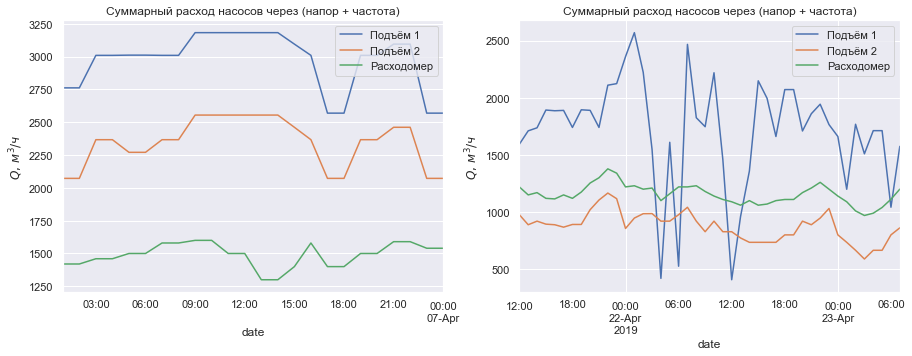

In [71]:
plot_by_date(2, [log[:num], log[num:]], ['flow lift 1', 'flow lift 2', 'flow'], lift_labels + ['Расходомер'], 
             'Суммарный расход насосов через (напор + частота)', '$Q,\, м^3/ч$')

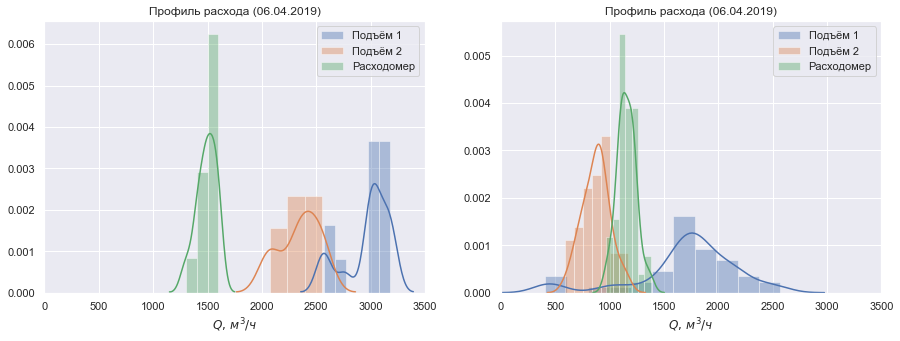

In [72]:
plot_dists(2, [log[:num], log[num:]], ['flow lift 1', 'flow lift 2', 'flow'], lift_labels + ['Расходомер'],
           ['Профиль расхода (06.04.2019)', 'Профиль расхода (21.04.2019)'], '$Q,\, м^3/ч$', '', xlim=3500)

##### Рабочие точки станции

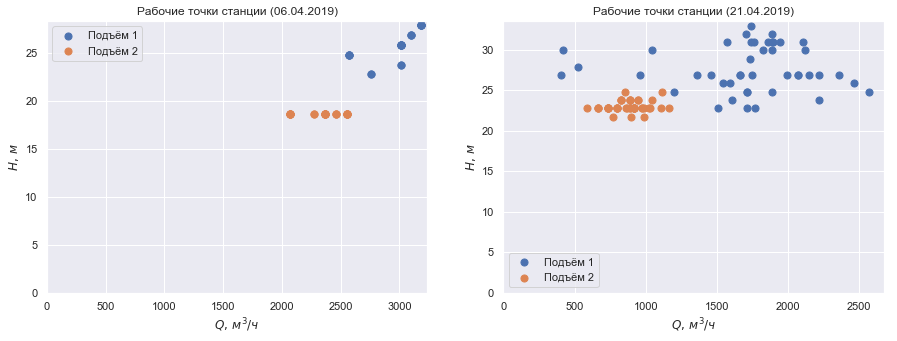

In [214]:
plot_flow_head(2, [log[:num], log[num:]], [['flow lift 1', 'head lift 1'], ['flow lift 2', 'head lift 2']], lift_labels, 
               ['C0', 'C1'], ['Рабочие точки станции (06.04.2019)', 'Рабочие точки станции (21.04.2019)'],
               '$Q,\, м^3/ч$', '$H,\, м$')

##### Потребляемая мощность

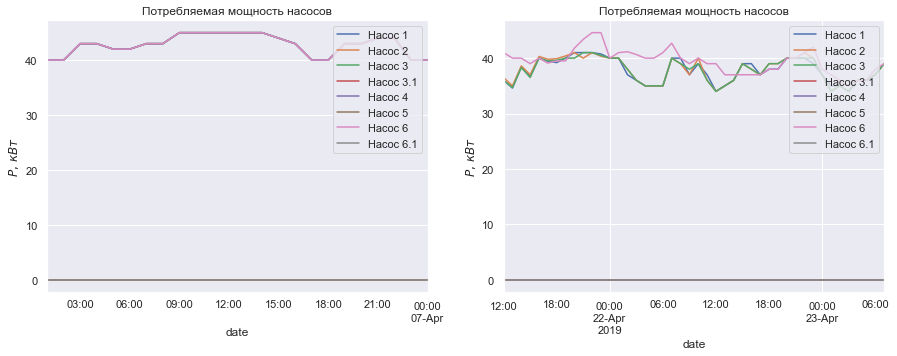

In [40]:
plot_by_date(2, [log[:num], log[num:]], freq_cols, pump_labels, 'Потребляемая мощность насосов', '$P,\, кВт$')

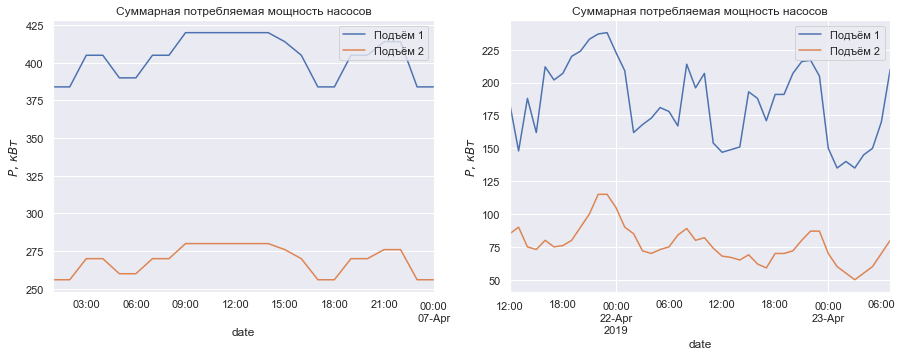

In [42]:
plot_by_date(2, [log[:num], log[num:]], ['power sup. lift 1', 'power sup. lift 2'], lift_labels, 
             'Суммарная потребляемая мощность насосов', '$P,\, кВт$')

##### Гидравлическая мощность

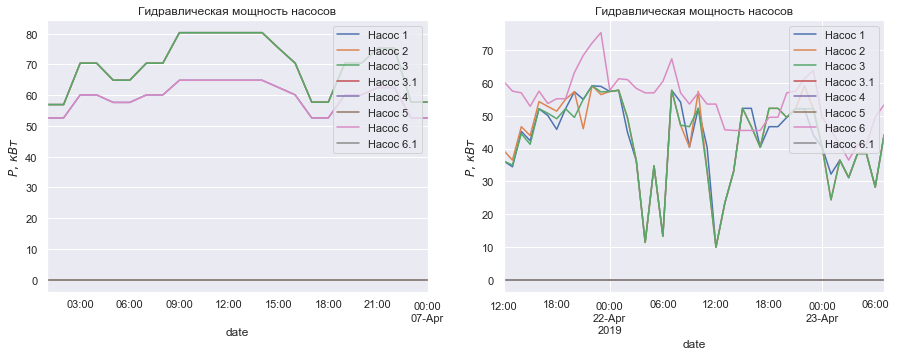

In [52]:
plot_by_date(2, [log[:num], log[num:]], power_hydro_cols, pump_labels, 'Гидравлическая мощность насосов', '$P,\, кВт$')

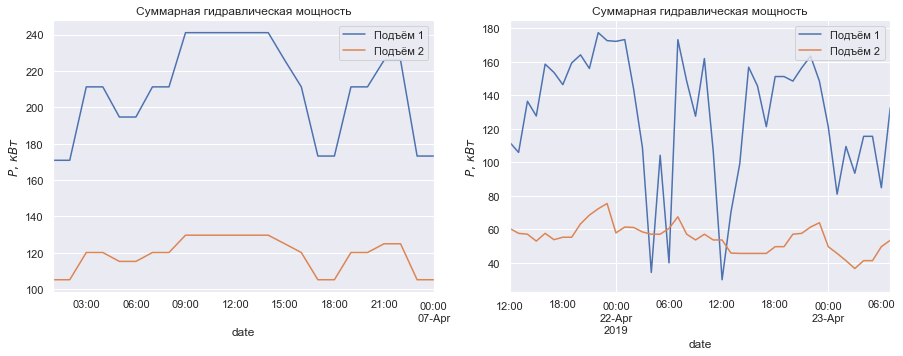

In [54]:
plot_by_date(2, [log[:num], log[num:]], ['power hydro lift 1', 'power hydro lift 2'], lift_labels, 
             'Суммарная гидравлическая мощность', '$P,\, кВт$')

##### КПД

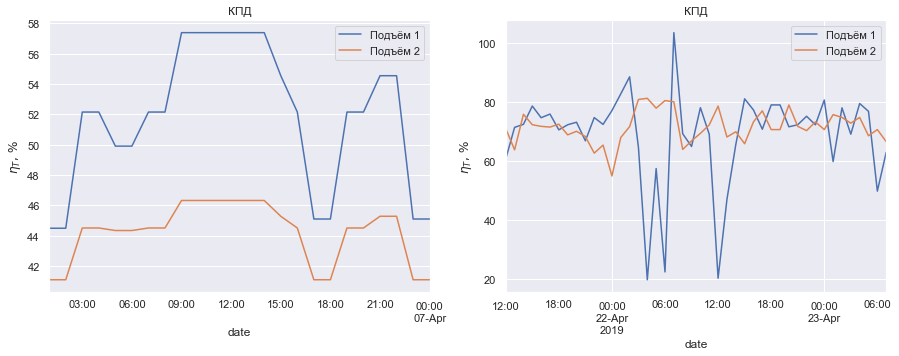

In [59]:
plot_by_date(2, [log[:num], log[num:]], ['eff actual lift 1', 'eff actual lift 2'], lift_labels, 'КПД', '$\eta_T,\, \%$')

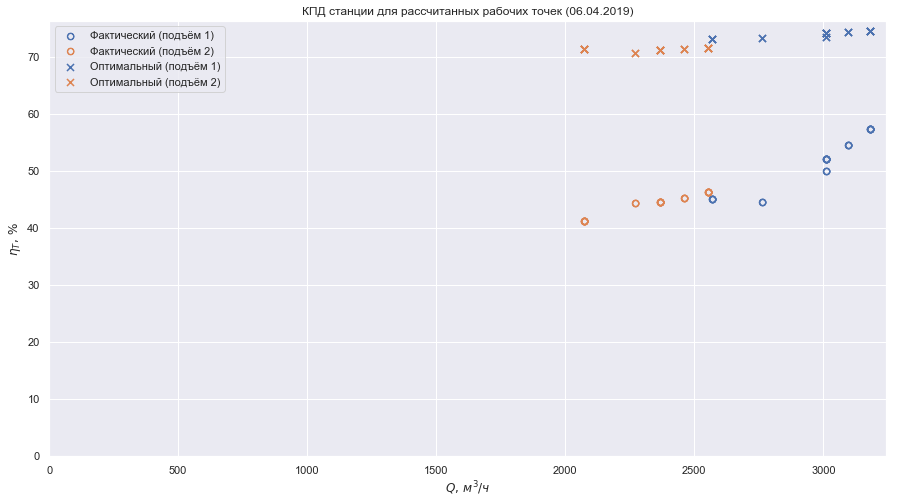

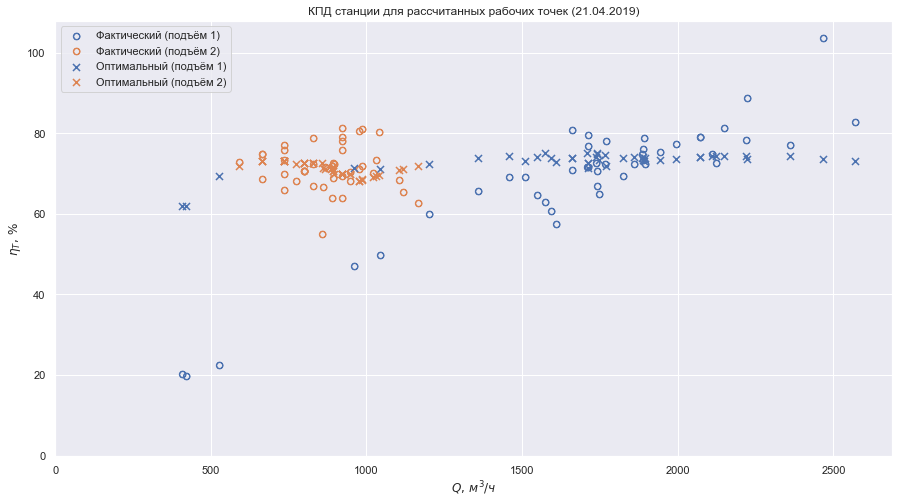

In [66]:
cols = [['flow lift 1', 'eff actual lift 1'], ['flow lift 2', 'eff actual lift 2'],
        ['flow lift 1', 'eff opt. lift 1'], ['flow lift 2', 'eff opt. lift 2']]

plot_scatter(log[:num], cols, fact_opt_labels, ['C0', 'C1', 'C0', 'C1'], ['$\u25EF$', '$\u25EF$', 'x', 'x'], 
             'КПД станции для рассчитанных рабочих точек (06.04.2019)', '$Q,\, м^3/ч$', '$\eta_T,\, \%$')

plot_scatter(log[num:], cols, fact_opt_labels, ['C0', 'C1', 'C0', 'C1'], ['$\u25EF$', '$\u25EF$', 'x', 'x'], 
             'КПД станции для рассчитанных рабочих точек (21.04.2019)', '$Q,\, м^3/ч$', '$\eta_T,\, \%$')

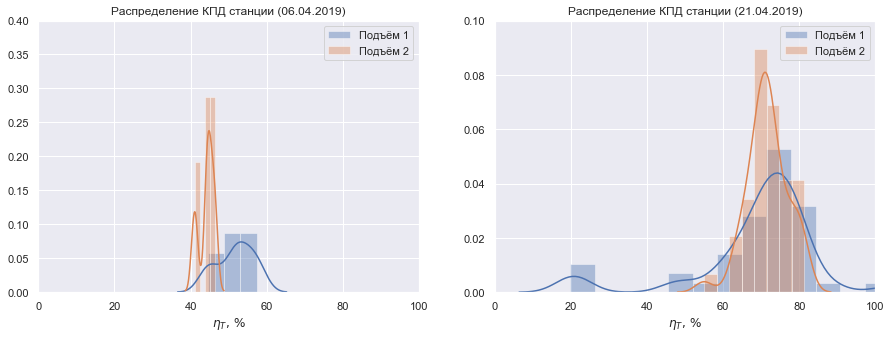

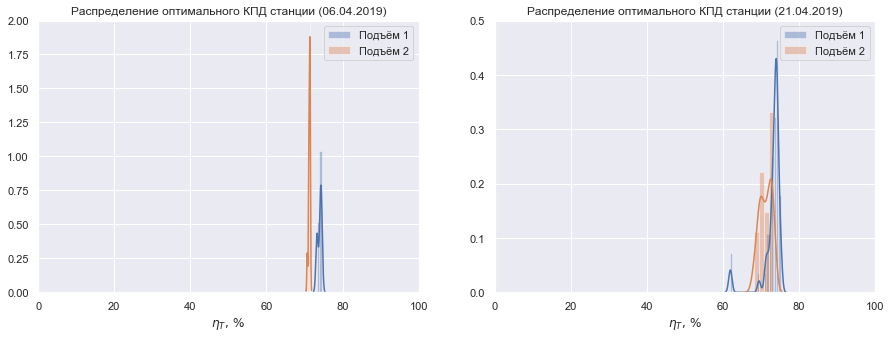

In [131]:
plot_dists(2, [log[:num], log[num:]], ['eff actual lift 1', 'eff actual lift 2'], lift_labels,
           ['Распределение КПД станции (06.04.2019)', 'Распределение КПД станции (21.04.2019)'], 
           '$\eta_T,\, \%$', '', xlim=100, ylim=[0.4, 0.1])
plot_dists(2, [log[:num], log[num:]], ['eff opt. lift 1', 'eff opt. lift 2'], lift_labels,
           ['Распределение оптимального КПД станции (06.04.2019)', 'Распределение оптимального КПД станции (21.04.2019)'], 
           '$\eta_T,\, \%$', '', xlim=100, ylim=[2, 0.5])

##### Удельный расход электроэнергии

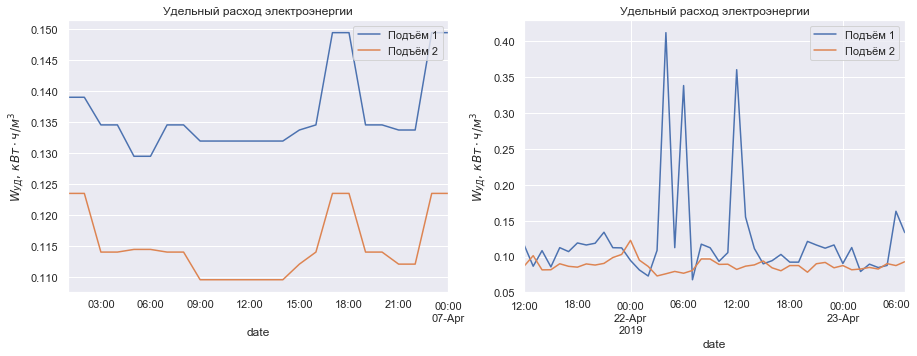

In [56]:
plot_by_date(2, [log[:num], log[num:]], ['power rate lift 1', 'power rate lift 2'], lift_labels,
             'Удельный расход электроэнергии', '$W_{УД},\, кВт \cdot ч/м^3$')

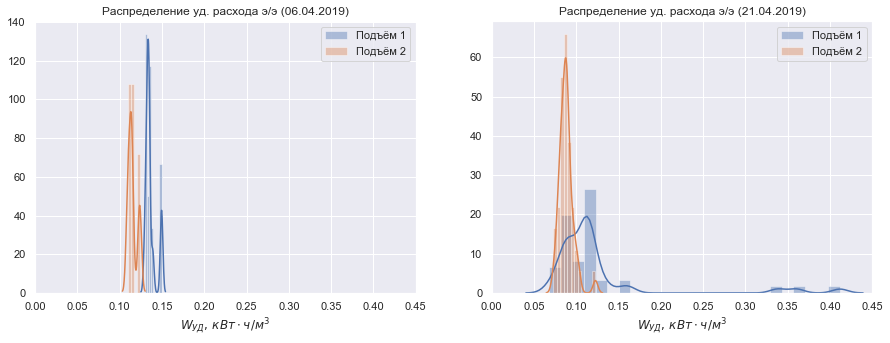

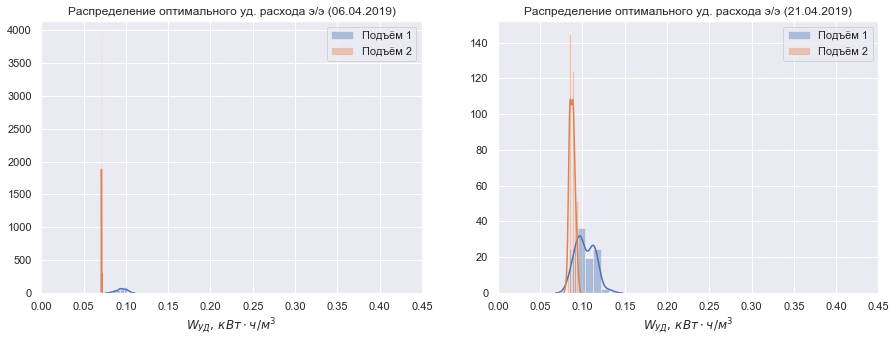

In [124]:
plot_dists(2, [log[:num], log[num:]], ['power rate lift 1', 'power rate lift 2'], lift_labels,
           ['Распределение уд. расхода э/э (06.04.2019)', 'Распределение уд. расхода э/э (21.04.2019)'], 
           '$W_{УД},\, кВт \cdot ч/м^3$', '', xlim=0.45)

plot_dists(2, [log[:num], log[num:]], ['power rate opt. lift 1', 'power rate opt. lift 2'], lift_labels, 
           ['Распределение оптимального уд. расхода э/э (06.04.2019)', 
            'Распределение оптимального уд. расхода э/э (21.04.2019)'], 
           '$W_{УД},\, кВт \cdot ч/м^3$', '', xlim=0.45)

##### Энергопотребление

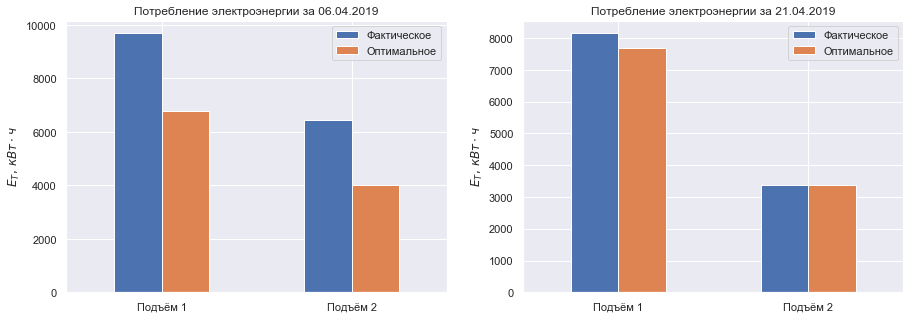

In [58]:
# потребление электроэнергии за рассматриваемый период

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fact = [pb_1.energy_1, pb_2.energy_1, pb_1.energy_2, pb_2.energy_2]
opt = [pb_1.energy_opt_1, pb_2.energy_opt_1, pb_1.energy_opt_2, pb_2.energy_opt_2]

pd.DataFrame({'fact': fact[:2], 'opt': opt[:2]}, index=lift_labels).plot.bar(rot=0, ax=axes[0])
axes[0].legend(["Фактическое", "Оптимальное"])
axes[0].set_ylabel('$E_{T},\, кВт \cdot ч$')
axes[0].set_title('Потребление электроэнергии за 06.04.2019')

pd.DataFrame({'fact': fact[2:], 'opt': opt[2:]}, index=lift_labels).plot.bar(rot=0, ax=axes[1])
axes[1].legend(["Фактическое", "Оптимальное"])
axes[1].set_ylabel('$E_{T},\, кВт \cdot ч$')
axes[1].set_title('Потребление электроэнергии за 21.04.2019')

plt.show()